# A realistic approach to finetuning in an enterprise environment
You’d have to be living under a rock not to notice the massive advancements in the LLM (Large Language Model) space since the release of ChatGPT in 2022. These breakthroughs have driven many companies and organizations to invest heavily in pushing the space forward, resulting in a wealth of open-source models that can be leveraged to build data products.

This is an excellent starting point, but many companies possess a significant amount of internal documents and other proprietary data that could greatly enhance their data products. Ideally, they would want to incorporate this data into their tools. To address this need, many providers have introduced fine-tuning services. For example, OpenAI offers fine-tuning for their GPT-4 model. This is a fantastic service that undoubtedly provides value to many clients. However, for data engineers like me who live and work in the EU, this is often not a viable option.

The EU is governed by the GDPR (General Data Protection Regulation), which imposes strict rules on how data can be used. Even before GDPR, many large enterprises were reluctant to share their data with external partners, making it challenging to use external fine-tuning services without undergoing resource-intensive compliance reviews. Consequently, many organizations opt to focus on other areas instead.

The goal of this blog post is to demonstrate how you can fine-tune some of these models in a restricted enterprise environment. To illustrate this, I will run everything on my personal laptop, a 2021 MacBook Pro with an M1 Max chip and 32 GB of RAM. While this is a fairly powerful machine, I believe it is realistic to expect access to equivalent resources within an enterprise setting. I’ll show you how to achieve this step-by-step.

## Me
First a bit about who I am. My name is Dilovan Celik, you are probably reading this on my GitHub. If you want to read more information from me, you can visit my substack [Thoughts on Data](https://dilovan.substack.com) or connect with me on [LinkedIn](https://www.linkedin.com/in/dilovancelik/). Now on to the main event. 

## The Project
To make this post more relatable, I’ll guide you through the process of building a Retrieval-Augmented Generation (RAG) system from scratch, where we will fine-tune the embedding algorithm. While building a RAG is an interesting project in itself, my primary hope is not only to show you how to build a RAG but also to empower you to experiment with creating your own products, even when you don’t have access to unlimited resources.

Before diving in, let’s take a look at what exactly we’ll be building.

### Retrieval Agumented Generation (RAG)
A RAG is a method to enhance an existing chatbot with your own data. Essentially, it involves building a layer on top of the chatbot that takes user input and enriches it with relevant context from your internal documents. (This, by the way, is a different approach to integrating your own data into a chatbot.)

The RAG enriches the original user query by embedding it and searching through a database of your internal documents, finding documents that are similar to the user's query.

A simplified illustration of the RAG architecture might look like this:

![Illustration of RAG architecture](./images/rag_illustration.png)

### Mette (Frederiksen, Danish PM) Bot
Our RAG will be an application where you can input a topic and retrieve the Danish Prime Minister Mette Frederiksen's opinion on the subject. The RAG will be enriched with speeches given by Mette Frederiksen.

The challenge is that these speeches are mostly in Danish. Since Danish is a relatively small language (approximately 6 million native speakers), it can be difficult to find a highly effective open-source embedding model. Even when choosing a multilingual model, danish typically represents only a small fraction of the training data.

Therefore, our approach will be to download a small multilingual embedding model and improve it for our specific data through fine-tuning.


## Fintunning Pipeline
Now that we have some background on what I'm trying to achieve lets look at the steps we need to take. 

1. Data Retrieval (We will not go through this, because every case is different)
2. Data Preparation
3. Establish Baseline for non Finetuned Model
4. Finetuning
5. Test to see if the model performance has improved
6. Sample code for simple RAG

As shown I will not go through the data retrieval part. I will skip this part, because the recommended approach varies depending on your data source. You can find my data in the folder data/taler

To avoid having to import libraries all over the place lets import the needed dependencies here:


In [2]:
import glob
import regex as re
from tqdm import tqdm
import ollama
import uuid
import json
from typing import List
from collections import defaultdict
import pandas as pd
import psycopg as pg
from ollama import chat, ChatResponse
import random
import itertools

from datasets import load_dataset, DatasetDict, Dataset

from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import TripletEvaluator

import torch.nn as nn

from peft import LoraConfig, TaskType
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

## Data Preperation
One of the most critical steps when fine-tuning a model is preparing your data properly. Before diving in, it's important to consider the specific goal of your application.

For example, imagine you are building an application where users can input a list of symptoms and receive the 10 most likely diagnoses. In this scenario, you need a model that can match the embedding of the symptom list with the embeddings of the diagnoses. Conversely, if your goal were to retrieve applicable laws based on a user's question, you would need to train the model to match questions to relevant legal texts.

In this example, our objective is to create a model that can take a subject (e.g., Crime, Unemployment, Climate Change) and match it with public speeches made by the Danish Prime Minister, Mette Frederiksen.

I have a folder containing 153 speeches by the Prime Minister. However, because these speeches cover a wide range of subjects, I need to break them into smaller, more manageable chunks.

A simple approach would be to split each speech into chunks of a fixed number of characters (e.g., 1,000 characters) with some overlap between chunks. This naive method can work quite well in many scenarios.

However, I encourage you to analyze your data for natural breaks that could serve as chunking boundaries. For instance, if you were working with legal texts, it might make sense to assign each article to its own chunk.

When reviewing my data, I noticed that longer speeches often included lines like **** or ---- as separators between different sections. I can use these as delimiters when chunking the text. For speeches that don't contain these separators, I will fall back on the naive approach, but instead of chunking by characters, I'll chunk by lines to maintain more natural context within each chunk.

This approach to data preparation will help ensure that our fine-tuned model produces more relevant and accurate results.
The code I wrote to handle chunking looks like this: 

In [3]:
total = 0
files = glob.glob("*.txt", root_dir="data/taler") # find all files in the folder data/taler
speech_chunks = {}
with tqdm(total=len(files), desc="Processing Files") as fpbar:
    for file_name in files:
        speech_name = file_name.replace(".txt", "")
        with open(f"data/taler/{file_name}", "r") as f:
            lines = f.readlines()
            total += len(lines)
        context_splits = []

        char_split = False
        for line in lines:
            if re.search("[a-zA-Z]", line) is None and "\n" != line:
                char_split = True
                break

        if char_split:
            context = []
            for line in lines:
                if re.search("[a-zA-Z]", line) is None and "\n" != line:
                    context_splits.append(" ".join(context))
                    context = []
                else:
                    context.append(line)
            if context != []:
                context_splits.append(" ".join(context))
        else:
            chunk_size = 10  # group size
            overlap = 2  # overlap size
            context_splits = [
                " ".join(lines[i : i + chunk_size])
                for i in range(0, len(lines), chunk_size - overlap)
            ]

        speech_chunks[speech_name] = context_splits
        fpbar.update(1)

Processing Files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 1999.64it/s]


We now have a Python object that looks something like this:

```Python
{
    "speech-1": ["chunk 1", "chunk 2", "chunk 3"],
    "speech-2": ["chunk 1", "chunk 2", "chunk 3"],
    ...
    "speech-n": ["chunk 1", "chunk 2", "chunk 3"],
}
```

It might be tempting to think we can simply feed this data into a "magic AI model box" and instantly get a neat embedding algorithm. Unfortunately, it’s not that straightforward.

As mentioned earlier, our goal is to create a model where a user can input a subject and retrieve a relevant chunk. To achieve this, we need not only the chunks themselves but also associated user inputs—in this case, the corresponding subjects. Since we don’t have predefined user inputs, we need to generate them.

One approach would be to manually annotate each chunk with subjects, which would undoubtedly yield the best results. However, this method would be far too time-consuming. Instead, we’ll generate synthetic data using an LLM (Large Language Model). For this task, I’ll use Microsoft’s phi4 model, running locally on my machine through [ollama](https://ollama.com) (If for some reason you are not allowed to download ollama, you can use the transformer library to create the same functionality in python, read more here: [Transformer Pipelines](https://huggingface.co/docs/transformers/main_classes/pipelines)). I've chosen this model because it offers a good balance between computational efficiency and output quality. However, I encourage you to experiment with different models to find what works best for your scenario.

The method for generating this synthetic data involves feeding each chunk of text into the model and asking it to generate relevant subjects.

Below is the prompt I use. The ## part is not part of the actual prompt but rather an English translation for non-Danish speakers:

```
Kontekst er nedenfor. ## Context below

---------------------
{context_str}
---------------------

Givet den givne kontekst og ingen anden viden. ## Given the context and no other knowledge
Genere op til 5 emner som kan beskrive konteksten,. ## Generate up to 5 subjects which can describe the context
Hvis der ikke er emner som let kan beskrive konteksten, besvar med <|NAN|> ## If there are no subjects which easily describe the context reply with <|NAN|>

Du må kun svarer med emnerne formattet skal være: Emne 1|Emne 2|...|Emne n| ## You are only allowed to reply with subjects in the following format: Subject 1| Subject 2|...|Subject n|
```

Let's try this approach with a toy example to see how it works.


In [5]:
PROMPT_TEMPLATE = """\
Kontekst er nedenfor.

---------------------
{context_str}
---------------------

Givet den givne kontekst og ingen anden viden.
Genere op til 5 emner som kan beskrive konteksten,. 
Hvis der ikke er emner som let kan beskrive konteksten, besvar med <|NAN|>

Du må kun svarer med emnerne formattet skal være: Emne 1|Emne 2|...|Emne n|
"""

In [8]:
context = speech_chunks[
    "mette-frederiksens-aabningstale-ved-folketingets-aabningsdebat"
][1]
print(f"Speech Chunk:\n{context}")

prompt = PROMPT_TEMPLATE.format(context_str=context)
res = ollama.chat("phi4", messages=[{"role": "user", "content": prompt}])
print(f"Response from phi4\n--------------------------------------------------------------\n{res.message.content}\n--------------------------------------------------------------")


Speech Chunk:

 Statsministeren sagde i sin åbningstale, at der er grund til at være stolt af Danmark. At Danmark er et godt samfund. Det er jeg fuldstændig enig i. Men tillad mig at være direkte her ved dagens start:
 Det Danmark, vi er stolte af, er ikke skabt på meget lave ydelser til børnefamilier. På en kriminel lavalder på 12 år. På topskattelettelser. Det Danmark, vi er stolte af, er skabt på det modsatte. På lige muligheder. På sociale fremskridt. På et progressivt skattesystem.
 Vi skal fortsætte. Vi skal bygge videre på verdens bedste samfund. Ikke det modsatte.
 Vi står over for et folketingsår, der bliver afgørende for Danmark. I mine øjne er der tre opgaver, der er vigtigere end alle andre.
 Vi skal have en finanslov på plads, der sikrer to ting. Styrket kernevelfærd. Flere arbejdspladser. Vi skal have et mere retfærdigt dagpengesystem. Vi skal hjælpe mennesker, der er på flugt og samtidig sikre, at den danske integration kan følge med.
 Regeringen har et valg. I kan vælge

As you can see we get subjects back in the way we want, and can now start generating data. 

In [5]:
dataset = {
    "speech": {},
    "queries": {},
    "corpus": {},
    "relevant_docs": {},
    "related_speech": {},
}

## This part is just to be able to track how far we are
total = 0
for speech, chunks in speech_chunks.items():
    total += len(chunks)

# TODO Batching 
with tqdm(total=total, desc="Generating Queries") as pbar:
    for speech, chunks in speech_chunks.items():
        speech_id = str(uuid.uuid4())
        dataset["speech"][speech_id] = speech
        for chunk in chunks:
            content_id = str(uuid.uuid4())
            dataset["corpus"][content_id] = chunk
            dataset["related_speech"][content_id] = speech_id
            prompt = PROMPT_TEMPLATE.format(context_str=chunk)
            res = ollama.chat("phi4", messages=[{"role": "user", "content": prompt}])
            reply = res.message.content
            if "<|NAN|>" in reply:
                pbar.update(1)
                continue
            for query in reply.split("|"):
                query_id = str(uuid.uuid4())
                dataset["queries"][query_id] = query
                dataset["relevant_docs"][query_id] = [content_id]
            pbar.update(1)

with open("data/base_data.json", "w") as f:
    f.write(json.dumps(dataset))

Generating Queries: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1333/1333 [2:13:20<00:00,  6.00s/it]


This process will take a while. On my MacBook Pro, it takes approximately 2.5 hours. However, if you have access to a machine with a more powerful GPU, such as an NVIDIA A100, you can significantly speed this up. Alternatively, you can use the pre-generated data, which is available in data/base_data.json.

The current code uses a "relevant document" setup. In this approach, each query (subject) and chunk is assigned a unique UUID, with a separate structure that maps each query to its relevant subjects.

Before moving forward, we need to address a couple of things:

1. **Remove Duplicate Subjects:** It’s possible that the same subject appears multiple times, so we need to clean this up.
2. **Organize Data for Model Training:** The data needs to be structured appropriately for training our model.

Additionally, I’ve added a related speech object to help us look up which speech a particular chunk originates from. This will prove useful later on. However, the data is currently not in the best shape, so let's do some cleaning.

Once we have cleaned the data, the next step is to determine how we want to train our model. A crucial part of this process involves selecting an appropriate loss function. The loss function is responsible for penalizing the model when it makes incorrect predictions and rewarding it when it makes correct predictions. It essentially guides the model toward better performance during training.

For the type of fine-tuning we are aiming for, it is common to organize the data into triplets. The triplet data format consists of:

- **Anchor:** The subject or query.
- **Positive:** A piece of context related to the anchor.
- **Negative:** A piece of context unrelated to the anchor.
  
An example of this format might look like:

- **Anchor:** Defense Spending
- **Positive:** "The new aircraft carrier is over budget but will bring much-needed capabilities."
- **Negative:** "It is important to invest education to give all children an equal opportunity."
  
However, a keen observer might notice that our dataset currently contains only positives. Therefore, we need to generate negatives to complete our triplets.

There are several ways to achieve this:

- **Generate Negatives with an LLM:** Similar to how we generated subjects earlier, we could use a large language model to create negative samples. This is a great approach, but can be very ressource intensive. 
- **Use an Unrelated Text Corpus:** Another approach is to introduce entirely unrelated text as negatives. For example, if you are working with clinical records, you could download annual reports from Goldman Sachs and use that text as your negative data. Unlike the above approach, this is very ressource efficient, but the results weaker when it comes to finetuning. Because the negative and positive are very far from eachother. 
- **Use the base model, to look for dissimilar samples in your corpus:** If the base model, has decent performance, this can be a very good compromise between the first and second approach. 
  
For this project, I opted for the second approach. I downloaded a dataset containing customer reviews and randomly selected reviews as negative samples.

Here's the code snippet demonstrating this approach:

In [6]:
data = dataset

# Strips away redundant whitespace from the subjects and 
# removes subjects which are note actual subjects
queries = defaultdict(list)
for key, value in data["queries"].items():
    if value == "" or "--" in value:
        continue
    queries[data["queries"][key].strip()].append(key)

# We go through the list chunks, and remove parts that does
# That does not include any information. This part is very 
# dependent on your data. So look through and implement the
# rules that makes sense for you

corpus = defaultdict(list)
pop_keys = []
for key, value in data["corpus"].items():
    value = " ".join(value.replace("Tale\n \n \n \n \n \n \n ", "").split())
    if value.isspace() or len(value) <= 60:
        pop_keys.append(key)
    data["corpus"][key] = value
    corpus[value].append(key)

for key in pop_keys:
    data["corpus"].pop(key)
    data["related_speech"].pop(key)


# We create a new query structure, which removes duplicate queries
# and remap the relevant documents to the new query ids
relevant_docs = defaultdict(list)
new_queries = {}
for query in queries.keys():
    id = str(uuid.uuid4())
    new_queries[id] = query
    query_ids = queries[query]
    for query_id in query_ids:
        for doc_id in data["relevant_docs"][query_id]:
            if doc_id not in pop_keys:
                relevant_docs[id].append(doc_id)

clean_data = {}
clean_data["query"] = new_queries
clean_data["relevant_docs"] = relevant_docs
clean_data["related_speech"] = data["related_speech"]
clean_data["corpus"] = data["corpus"]

with open("data/cleaned_base_data.json", "w") as out:
    json.dump(clean_data, out)

Testing Query Embedding Span:   0%|                                                                                                                                         | 300638/22595801761 [14:37<18317:53:18, 342.64it/s]


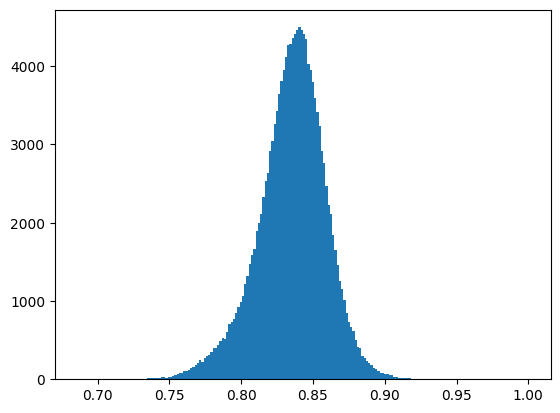

In [8]:
with open("data/cleaned_base_data.json", "r") as f:
    data = json.loads(f.read())

negatives: pd.DataFrame = pd.read_csv("data/negatives.csv")["review_text"]

triplets = []

model_name = "intfloat/multilingual-e5-small"
model = SentenceTransformer(model_name)

# Test the model

sims = []
sim_lkp = {}
"""
encoded_queries = {}
with tqdm(total=len(data["query"]), desc="embedding_queries") as pbar:
    for key, value in data["query"].items():
        emb = model.encode(value)
        encoded_queries[key] = emb
        pbar.update(1)
"""
with tqdm(total=len(encoded_queries.keys()) ** 2, desc="Testing Query Embedding Span") as pbar:
    for x_id, x_emb in encoded_queries.items():
        sim_lkp[x_id] = {}
        for y_id, y_emb in encoded_queries.items():
            if x_id == y_id:
                pbar.update(1)
                continue
                
        dot_product = np.dot(x_emb, y_emb)
        magnitude_x = np.linalg.norm(x_emb)
        magnitude_y = np.linalg.norm(y_emb)
        cosine_similarity = dot_product / (magnitude_x * magnitude_y)
        sims.append(cosine_similarity)
        sim_lkp[x_id][y_id] = cosine_similarity
        pbar.update(1)

x = np.array(sims)
plt.hist(x, bins=200)
plt.show()

Testing Query Embedding Span:   0%|                                                                                                                                         | 300638/22595801761 [14:37<18317:53:18, 342.64it/s]


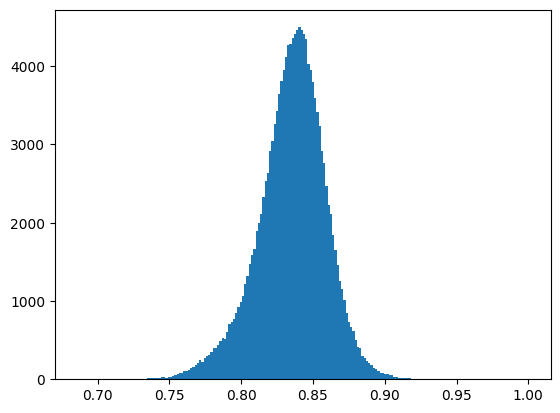

In [8]:
with open("data/cleaned_base_data.json", "r") as f:
    data = json.loads(f.read())

negatives: pd.DataFrame = pd.read_csv("data/negatives.csv")["review_text"]

triplets = []

model_name = "intfloat/multilingual-e5-small"
model = SentenceTransformer(model_name)

# Test the model

sims = []
sim_lkp = {}
"""
encoded_queries = {}
with tqdm(total=len(data["query"]), desc="embedding_queries") as pbar:
    for key, value in data["query"].items():
        emb = model.encode(value)
        encoded_queries[key] = emb
        pbar.update(1)
"""
with tqdm(total=len(encoded_queries.keys()) ** 2, desc="Testing Query Embedding Span") as pbar:
    for x_id, x_emb in encoded_queries.items():
        sim_lkp[x_id] = {}
        for y_id, y_emb in encoded_queries.items():
            if x_id == y_id:
                pbar.update(1)
                continue
                
        dot_product = np.dot(x_emb, y_emb)
        magnitude_x = np.linalg.norm(x_emb)
        magnitude_y = np.linalg.norm(y_emb)
        cosine_similarity = dot_product / (magnitude_x * magnitude_y)
        sims.append(cosine_similarity)
        sim_lkp[x_id][y_id] = cosine_similarity
        pbar.update(1)

x = np.array(sims)
plt.hist(x, bins=200)
plt.show()

In [59]:
with open("data/cleaned_base_data.json", "r") as f:
    data = json.loads(f.read())

negatives: pd.DataFrame = pd.read_csv("data/negatives.csv")["review_text"]

total = 0
for id, relevant_docs in data["relevant_docs"].items():
    total += len(relevant_docs)

triplets = []

with tqdm(total=total, desc="creating positive negative pairs") as pbar:
    for query_id, doc_ids in data["relevant_docs"].items():
        anchor = data["query"][query_id]
        anchor_emb = model.encode(anchor)
        for id in doc_ids:
            x = True
            while x:
                negative_id, negative_query = random.choice(list(data["query"].items()))
                negative_emb = model.encode(negative_query)
                
                dot_product = np.dot(anchor_emb, negative_emb)
                magnitude_A = np.linalg.norm(anchor_emb)
                magnitude_B = np.linalg.norm(negative_emb)
                cosine_similarity = dot_product / (magnitude_A * magnitude_B)
                if cosine_similarity <= 0.81:
                    _id = random.choice(data["relevant_cods"])
                    negative = random.choice(data[]
                    x = False
                    
                    
                    
            triplets.append(
                {
                    "anchor": anchor,
                    "positive": data["corpus"][id],
                    "negative": negative,
                }
            )
            pbar.update(1)

creating positive negative pairs:   0%|                                                                                                                                                  | 26/150672 [00:11<18:19:38,  2.28it/s]


KeyboardInterrupt: 

Now that we have our triplet data, the last thing is to split our data into Train, Test and Validation.
We use Train data to finetune our model, we use test data to estimate the performance of the model during training, and validition to ensure that we did not just find a model that fit our test data well. 

In [9]:
train_triplet, val_triplet = train_test_split(pd.DataFrame(triplets), test_size=0.2)
train_triplet, test_triplet = train_test_split(
    pd.DataFrame(train_triplet), test_size=0.2
)

train_triplet.to_json("data/triplet_data_train.json")
test_triplet.to_json("data/triplet_data_test.json")
val_triplet.to_json("data/triplet_data_val.json")

dataset: DatasetDict = {
    "train": Dataset.from_pandas(train_triplet, preserve_index=False),
    "test": Dataset.from_pandas(test_triplet, preserve_index=False),
    "validation": Dataset.from_pandas(val_triplet, preserve_index=False),
}

In [9]:
train_triplet, val_triplet = train_test_split(pd.DataFrame(triplets), test_size=0.2)
train_triplet, test_triplet = train_test_split(
    pd.DataFrame(train_triplet), test_size=0.2
)

train_triplet.to_json("data/triplet_data_train.json")



test_triplet.to_json("data/triplet_data_test.json")
val_triplet.to_json("data/triplet_data_val.json")

dataset: DatasetDict = {
    "train": Dataset.from_pandas(train_triplet, preserve_index=False),
    "test": Dataset.from_pandas(test_triplet, preserve_index=False),
    "validation": Dataset.from_pandas(val_triplet, preserve_index=False),
}

### Baseline Model and Valuation Strategy

Our data is now ready, but before we start finetuning our model, we should consider how we are going to decide whether or not the finetuned model is better than the baseline one. 

To do this we have to do the following steps:
1. Download a Baseline model
2. Find a valuation method
3. Valuate the Baseline model
4. Finetune the model
5. Valuate the finetuned model

The first thing we will do is to download the baseline model from HuggingFace, using the SentenceTransformer library. I have chosen the [multilingual-e5-small](https://huggingface.co/intfloat/multilingual-e5-small) model. I have chosen this model because it has a good baseline performance, and is small enough to train on my laptop.

In [10]:
model_name = "intfloat/multilingual-e5-small"
model = SentenceTransformer(model_name)

# Test the model
emb = model.encode("Hello World")
print("Vector Size: ", len(emb))

Vector Size:  384


Now that we've downloaded our baseline model, let's take a moment to think about how to best evaluate its performance.

Now that we've downloaded our baseline model, let's spend some time thinking about how to best evaluate our model.

A good place to start is here: [SentenceTransformer Evaluator Classes](https://sbert.net/docs/sentence_transformer/training_overview.html#evaluator).

Going through the list, there are several that are interesting, but the one that fits our data best is the [Triplet Evaluator](https://sbert.net/docs/package_reference/sentence_transformer/evaluation.html#sentence_transformers.evaluation.TripletEvaluator).

What the Triplet Evaluator does is compare the similarity between the anchor and the positive, as well as between the anchor and the negative. It then returns a percentage representing the proportion of records where the anchor embedding was closer to the positive embedding than to the negative. So, a result of 0.8 means that in 80% of cases, the anchor was closer to the positive than to the negative.

We can run the model on our data using the following code.

In [11]:
dev_evaluator = TripletEvaluator(
    anchors=dataset["test"]["anchor"],
    positives=dataset["test"]["positive"],
    negatives=dataset["test"]["negative"],
    name="dev_evaluator",
)

In [12]:
dev_evaluator(model)

{'dev_evaluator_cosine_accuracy': 0.9143446683883667}

With our test data, we get a result of 0.91 using our baseline model. This means that in 91% of cases, the baseline model will place the anchor closer to the positive than to the negative.

This is a great evaluation to start with, but in reality, this is not what we are truly interested in. We want to know whether inputting a subject will return related chunks of text. So, let's try to write a custom evaluation script. I will base my model on the Recall@K metric. The metric simply tests whether the anchor returns the positive in its top K results.

We will modify this to check if any of the related documents are in the top K results. Additionally, we will introduce a metric to show the percentage of relevant documents present in the top K results.

Before writing this test, we need to store the embeddings somewhere so we can query them. Many databases can handle this, but I've chosen to use Postgres with the PG Vector extension. Here's how to set it up in your Postgres database:

First, install the extension by running the following command:
```sql
CREATE EXTENSION vector;
```
Then, we will create two tables to store our embeddings: one for our baseline embeddings and another for the fine-tuned embeddings:
```sql
CREATE TABLE embeddings_base (id bigserial PRIMARY KEY, speech VARCHAR, context_id VARCHAR, context VARCHAR, embedding vector(384))
CREATE TABLE embeddings (id bigserial PRIMARY KEY, speech VARCHAR, context_id VARCHAR, context VARCHAR, embedding vector(384))
```
You might wonder about the vector(384) datatype. This simply means we are storing a vector of size 384. If you are unsure about the size of your embedding, you can find out by running:
```python
len(model.encode("Hello"))
```
Now that our table is ready for embeddings, we can load them. Let's do that using the following code.

In [13]:
def write_to_db(speech: str, context_id: str, context: str, embedding: List, write_to_base: bool) -> None:
    conn = pg.connect("dbname=vector_rag user=postgres password=postgres")
    conn.autocommit = True
    cur = conn.cursor()
    if write_to_base:
        cur.execute(
            "INSERT INTO embeddings_base (speech, context_id, context, embedding) VALUES (%s, %s, %s, %s)",
            (speech, context_id, context, str(embedding)),
        )
    else:
        cur.execute(
            "INSERT INTO embeddings (speech, context_id, context, embedding) VALUES (%s, %s, %s, %s)",
            (speech, context_id, context, str(embedding)),
        )
    cur.close()
    conn.close()

In [14]:
with tqdm(total=len(data["corpus"].keys()), desc="Saving embeddings") as pbar:
    for id, context in data["corpus"].items():
        speech_name = data["related_speech"][id]
        embedding = model.encode(context).tolist()
        write_to_db(speech_name, id, context, embedding, True)
        pbar.update(1)

Saving embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1173/1173 [01:24<00:00, 13.90it/s]


Then we can implement our recall k methods and test our baseline model

In [15]:
# Add lookup to make checks faster
data["query_lk"] = {}
for key, value in data["query"].items():
    data["query_lk"][value] = key

def recall_k(query: str, model: SentenceTransformer, k: int, data: dict, check_base: bool) -> float:
    query_id = data["query_lk"][query]
    expected_ids = data["relevant_docs"][query_id]
    embedded_query = model.encode(query).tolist()

    conn = pg.connect("dbname=vector_rag user=postgres password=postgres")
    conn.autocommit = True
    cur = conn.cursor()
    if check_base:
        cur.execute(
            "SELECT context_id FROM embeddings_base ORDER BY embedding <=> %s::vector LIMIT %s;",
            (str(embedded_query), str(k)),
        )
    else: 
        cur.execute(
            "SELECT context_id FROM embeddings ORDER BY embedding <=> %s::vector LIMIT %s;",
            (str(embedded_query), str(k)),
        )
        
    results = [row[0] for row in cur.fetchall()]

    cur.close()
    conn.close()

    min_res = min(len(expected_ids), k)
    result_per = len(set(results) & set(expected_ids)) / min_res
    
    result_k = 1.0 if set(results) & set(expected_ids) else 0.0

    return result_k, result_per


recall_10 = test_triplet.apply(
        lambda x: recall_k(x["anchor"], model, 10, data, True), axis=1
    )
recall_10 = pd.DataFrame(recall_10.tolist(), index=recall_10.index)
print("Recall@10 Metric: ", recall_10[0].sum() / test_triplet.shape[0])
print("Recall@10 Metric %: ", recall_10[1].sum() / test_triplet.shape[0])


recall_4 = test_triplet.apply(
        lambda x: recall_k(x["anchor"], model, 4, data, True), axis=1
    )
recall_4 = pd.DataFrame(recall_4.tolist(), index=recall_4.index)
print("Recall@4 Metric: ", recall_4[0].sum() / test_triplet.shape[0])
print("Recall@4 Metric %: ", recall_4[1].sum() / test_triplet.shape[0])


Recall@10 Metric:  0.2868937048503612
Recall@10 Metric %:  0.2770979736924009
Recall@4 Metric:  0.1785345717234262
Recall@4 Metric %:  0.1719986240110079


With our baseline, we can now try to fine-tune our model to see if we can improve its performance.

### Fine-Tuning with Limited Compute and Memory
Although we've chosen a very small model, my laptop does not have enough memory to train it locally. This leaves me with two options:

Rent a Bigger Machine: This would certainly make the process easier, but I've always found it more interesting to work within limitations.
Work Within Constraints: I've decided to take the more challenging route and explore ways to fine-tune the model using limited resources.
One promising solution is to perform fine-tuning using [Low Rank Adaptation (LoRA)](https://arxiv.org/pdf/2106.09685). 

When using LoRA, we freeze all the parameters in the baseline model and train a smaller adaptation layer, which is then multiplied onto the original weights. This significantly reduces the number of parameters we need to train. According to the original paper, this approach can reduce memory requirements threefold.
![LowRank Adaptation](images/LoRA.png)

Let's see the difference in trainable parameters before and after applying the LoRA adapter:

In [16]:
trainable_params = 0
all_params = 0

for name, param in model.named_parameters():
    all_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
        # print(f"{name}: shape={param.shape}, params={param.numel()}")



print(f"Total model parameters:    {all_params:,}")
print("-" * 70)
print(f"Total trainable parameters before LoRA: {trainable_params:,}")
print(f"Trainable Percentage trainable before LoRA:     {100 * trainable_params / all_params:.2f}%")
print("-" * 70)
## Adding LoRA Adapter
peft_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    target_modules=["query", "key", "value", "dense"],
    lora_dropout=0.1,
)
model.add_adapter(peft_config)

trainable_params_lora = 0
for name, param in model.named_parameters():
    all_params += param.numel()
    if param.requires_grad:
        trainable_params_lora += param.numel()
print(f"Total trainable parameters after LoRA: {trainable_params_lora:,}")
print(f"Trainable Percentage trainable after LoRA:     {100 * trainable_params_lora / all_params:.2f}%")
print("-" * 70)

Total model parameters:    117,653,760
----------------------------------------------------------------------
Total trainable parameters before LoRA: 117,653,760
Trainable Percentage trainable before LoRA:     100.00%
----------------------------------------------------------------------
Total trainable parameters after LoRA: 669,696
Trainable Percentage trainable after LoRA:     0.28%
----------------------------------------------------------------------


As you can see, we reduce the trainable parameters by 99.72%, which is quite significant and ensures that this can run on my Mac. Now, let's get to the training.

First, we need to decide on a loss function. To do that, I referred to the [Sentence Transformer Loss Overview](https://sbert.net/docs/sentence_transformer/loss_overview.html), and found that MultipleNegativesRankingLoss fits my data well.

Second, we need to set some hyperparameters in our training arguments. There is no one-size-fits-all solution when choosing hyperparameters. From what I've read, the best approach is to experiment. Below are the hyperparameters I've chosen. I’d like to point out that the low batch size of 8 is primarily due to my memory limitations.

In [17]:
loss = MultipleNegativesRankingLoss(model)

args = SentenceTransformerTrainingArguments(
    output_dir="../models/multilingual-e5-small-finetune-danish-subject",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    bf16=True,  
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch according to the documentation
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=25,
    logging_first_step=True,
)

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    loss=loss,
)
trainer.train()

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss
100,2.108800,1.862558
200,0.956600,0.832888
300,0.886300,0.748309
400,0.823600,0.715428
500,0.772200,0.690172
600,0.783000,0.671355
700,0.737700,0.661641
800,0.823900,0.651434
900,0.743400,0.644150
1000,0.661100,0.641188


TrainOutput(global_step=1452, training_loss=0.8919132413450351, metrics={'train_runtime': 2756.9916, 'train_samples_per_second': 4.213, 'train_steps_per_second': 0.527, 'total_flos': 0.0, 'train_loss': 0.8919132413450351, 'epoch': 2.9979338842975207})

Now that we have a trained model, and before we test it, I would like to share a bit about what I look for in the logging. First, I check to see if there is a steadily decreasing validation loss throughout the training process.

What can sometimes happen is that while the training loss continues to decrease, the validation loss stops improving. This is usually a sign of overfitting the model.

Second, I notice that even though my training loss is generally decreasing, there are occasional spikes. This is probably due to the small batch size. Unfortunately, I cannot change this because of memory limitations.

Now, we can run our test again to see if performance has improved. To do this, we need to re-embed our corpus using the fine-tuned model.

In [18]:
with tqdm(total=len(data["corpus"].keys()), desc="Saving embeddings") as pbar:
    for id, context in data["corpus"].items():
        speech_name = data["related_speech"][id]
        embedding = model.encode(context).tolist()
        write_to_db(speech_name, id, context, embedding, False)
        pbar.update(1)

Saving embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1173/1173 [02:38<00:00,  7.39it/s]


And finally we can test

In [19]:

recall_10 = test_triplet.apply(
        lambda x: recall_k(x["anchor"], model, 10, data, False), axis=1
    )
recall_10 = pd.DataFrame(recall_10.tolist(), index=recall_10.index)
print("Recall@10 Metric: ", recall_10[0].sum() / test_triplet.shape[0])
print("Recall@10 Metric %: ", recall_10[1].sum() / test_triplet.shape[0])


recall_4 = test_triplet.apply(
        lambda x: recall_k(x["anchor"], model, 4, data, False), axis=1
    )
recall_4 = pd.DataFrame(recall_4.tolist(), index=recall_4.index)
print("Recall@4 Metric: ", recall_4[0].sum() / test_triplet.shape[0])
print("Recall@4 Metric %: ", recall_4[1].sum() / test_triplet.shape[0])

Recall@10 Metric:  0.4716202270381837
Recall@10 Metric %:  0.44813381492948057
Recall@4 Metric:  0.3240454076367389
Recall@4 Metric %:  0.30822153422772613


GREAT SUCCES!!!!! It looks like we've improved our model on all metrics. We did not have to send our data anywhere :D 

Before we finish for today, I would like to add a few words to the recall metrics. To b honest the result does not look that great.
The reason is that, we are looking for very specific values. But when we look at the actual data what we see is the queries finding 
relevant text. Just not the specific documents we were looking for. The reason is that when our model generated subjects. It could generate
multiple subjects which are very close in meaning to eachother. 

For instance we have 143 subjects with the word *pandemic* (pandemi in danish), this means that when testing for one of the pandemic subjects, 
we might get a relevant chunk from a different pandemic subject.

I Would like for you to think at these measures as a way to compare the model performance before and after finetuning, and not as an absolute truth.

In [20]:
len([subject for subject in data["query_lk"].keys() if "pandemi" in subject.lower()])

143

Now lets built a simple RAG application. Having the model this does not take a lot of code, which can be found below

In [37]:
METTE_PROMPT_TEMPLATE = """\
Du er en LLM som giver svarer på hvad Mette Frederiksen syntes om {question}. \
Du må kun besvarer baseret af de nedenstående citater, Du skal kun komme med et enkelt svar som er på Dansk \

---------------------
{context_str}
---------------------
"""

def rag():
    while True:
        ### First we ask the user for input
        query = input("Hvilket emne vil du høre Mette Frederiksens mening om? Skriv \\stop hvis du vil lukke programmet. \n\n")

        ### Check if user wants to exit
        if query == "\\stop":
            print("Farvel")
            break
            
        print("Tænker ...")
        emb = model.encode(query).tolist() ### Encode input
        
        print("Henter citater...")
        ### Query Database for relevant context
        conn = pg.connect("dbname=vector_rag user=postgres password=postgres")
        conn.autocommit = True
        cur = conn.cursor()
        
        cur.execute(
            "SELECT speech, context FROM embeddings ORDER BY embedding <-> %s::vector LIMIT 5;",
            (str(emb),),
        )
        
        result = cur.fetchall()
        
        context_all = []
        speeches =  []
        for row in result:
            speech = row[0]
            speeches.append(speech)
            context_all.append(f"'{row[1]}'")

        ### Generate Prompt
        prompt = METTE_PROMPT_TEMPLATE.format(context_str="\n\n".join(list(set(context_all))), question=query)
        
        cur.close()
        conn.close()
        
        print("Prøver at formulere mig...")
        
        res: ChatResponse = chat(model='phi4', messages=[
          {
            'role': 'user',
            'content': prompt,
          },
        ])
        print(res.message.content)
        print("\n\nLink til Taler og Citater som er valgt:")
        for row in result:
            print("-" * 100)
            print(f"Context:\n{row[1]}")
            print(f"\nLink: https://www.dansketaler.dk/tale/{row[0]}\n")

In [38]:
rag()

Hvilket emne vil du høre Mette Frederiksens mening om? Skriv \stop hvis du vil lukke programmet. 

 Kunstig Intelligens


Tænker ...
Henter citater...
Prøver at formulere mig...
This passage reflects on the current societal landscape, focusing particularly on the role of artificial intelligence (AI) and its implications. Here's a breakdown:

1. **Artificial Intelligence and Change**:
   - The text highlights AI as a transformative force in society, drawing parallels to past technological revolutions like computers defeating humans at chess.
   - It acknowledges both positive potential—such as solving complex societal problems—and negative aspects, including misuse for misinformation or manipulation.

2. **Ethical Concerns and Regulation**:
   - There is an urgent call for ethical considerations and regulation regarding AI's development and use to prevent harm and ensure it benefits society democratically.
   - The passage suggests that current mechanisms are insufficient, particularly in protecting vulnerable groups like children from potential exploitation by AI technologies.

3. **Societal Responsibilit

Hvilket emne vil du høre Mette Frederiksens mening om? Skriv \stop hvis du vil lukke programmet. 

 Børnefamiliers rolle


Tænker ...
Henter citater...
Prøver at formulere mig...
Mette Frederiksen understregede betydningen af at tage sig af børnefamilier og fremhævede vigtigheden af at møde hver enkelt barn med et ord om tillid. Hun anerkendte de mange pædagoger, der arbejder med vores børn, men påpegede også den afgørende rolle for familien og samfundet i at sikre børnenes trivsel. Frederiksen talte om konkrete eksempler på forsømmelse og vold, hvilket understregede behovet for et stærkt samfund, der kan beskytte og hjælpe alle børn. Hun betragtede det som en kamp for både nuværende sikkerhed og fremtidig trivsel af danske børn.


Link til Taler og Citater som er valgt:
----------------------------------------------------------------------------------------------------
Context:
Men lige bag jer, der står en kæreste. En ægtefælle. En mor. En far. En bror. En ven. Et barn. Eller en lillesøster som mig selv.
	Link: https://www.dansketaler.dk/tale/3cf235ec-fa96-4e5f-8e4f-a66ccf5f8d2c

------------------------

Hvilket emne vil du høre Mette Frederiksens mening om? Skriv \stop hvis du vil lukke programmet. 

 \stop


Farvel
